In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] =15,6

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("DataSet/AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#Changing month column using lambda function 
#year string is 0-4 while month string starting from 5 (eg: 1967-05)
df["Month"]=df["Month"].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
df=df.set_index("Month")
df.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


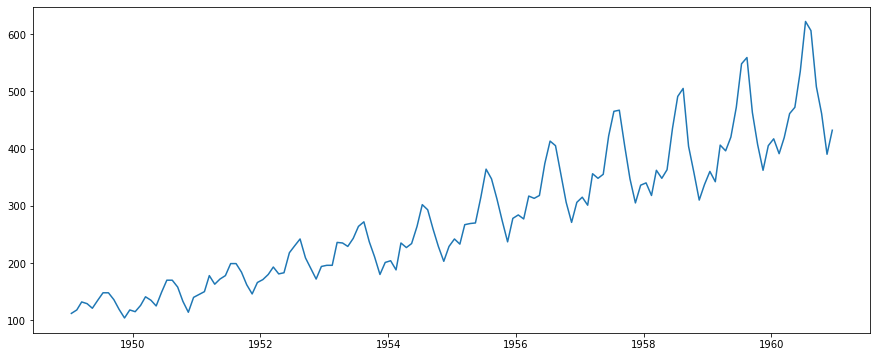

In [4]:
ts=df["#Passengers"]
plt.plot(ts)
#shows a overall increase(upward trend) with some seasonality in it

In [5]:
#transforming series using log decomposition
ts_log = np.log(ts)

In [6]:
#stationarity check ,for roling statistics and Dickey–Fuller test
def stationarity_check(timeseries):
    rolmean = timeseries.rolling(window=52,center=False).mean()
    rolstd = timeseries.rolling(window=52,center =False).std()
    
    orig = plt.plot(timeseries,color="blue",label="Original")
    mean = plt.plot(rolmean,color="red",label="Rolling Mean")
    std = plt.plot(rolstd,color= "black",label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block = False)
    
    print("Result of Dicky-Fuller Test:")
    dftest = adfuller(timeseries,autolag="AIC")
    dfoutput = pd.Series(dftest[0:4],index=["Test Statistic","p-value","#Lags Used","Number of Observation Used"])
    
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] =value
    print(dfoutput)

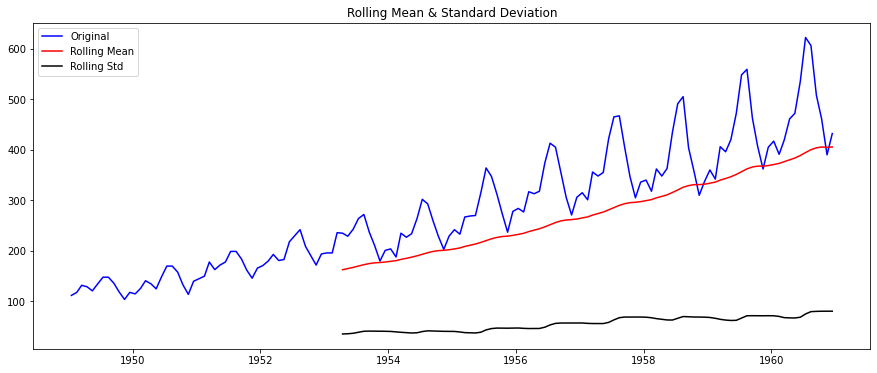

Result of Dicky-Fuller Test:
Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


In [7]:
stationarity_check(df["#Passengers"])

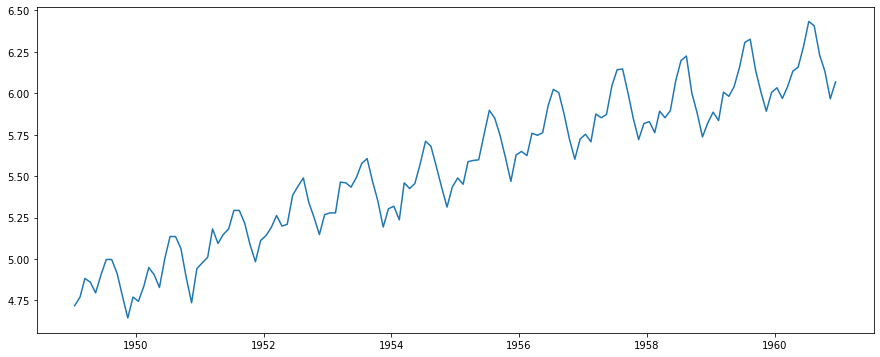

In [8]:
#ploting the moving average
plt.plot(ts_log)

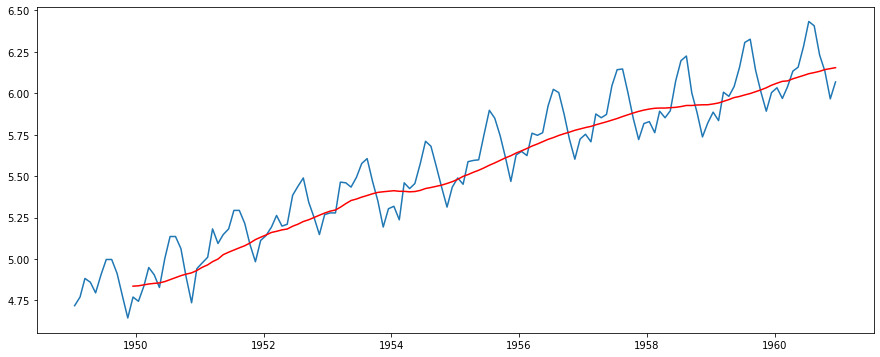

In [9]:
movingAverage = ts_log.rolling(window =12).mean()
movingSTD = ts_log.rolling(window =12).std()
plt.plot(ts_log)
plt.plot(movingAverage,color="red")

In [10]:
#mvDif - moving differance
ts_log_mvDif = ts_log-movingAverage
ts_log_mvDif.head(12)

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [11]:
ts_log_mvDif.dropna(inplace= True )
ts_log_mvDif.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

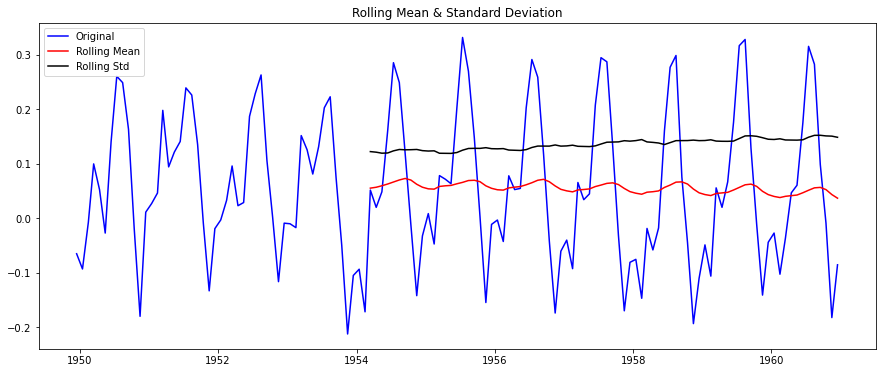

Result of Dicky-Fuller Test:
Test Statistic                 -3.162908
p-value                         0.022235
#Lags Used                     13.000000
Number of Observation Used    119.000000
Critical Value (1%)            -3.486535
Critical Value (5%)            -2.886151
Critical Value (10%)           -2.579896
dtype: float64


In [12]:
stationarity_check(ts_log_mvDif)

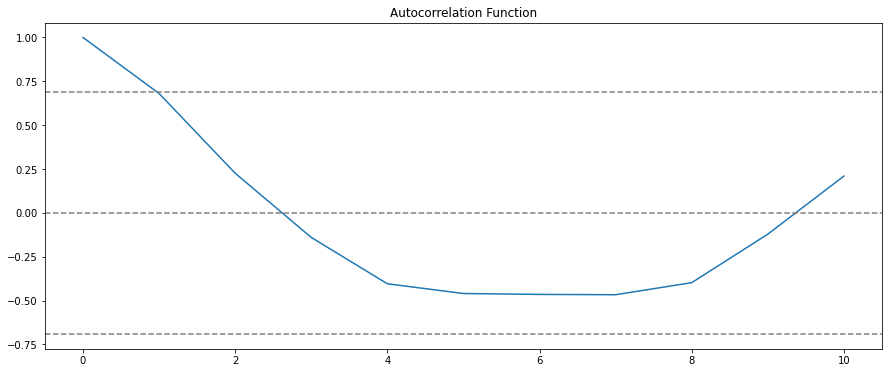

In [13]:
plt.plot(np.arange(0,11),acf(ts_log_mvDif,nlags=10))
plt.axhline(y=0,linestyle="--",color= "gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mvDif)),linestyle ="--",color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_mvDif)),linestyle="--",color="gray")
plt.title("Autocorrelation Function")
plt.show()

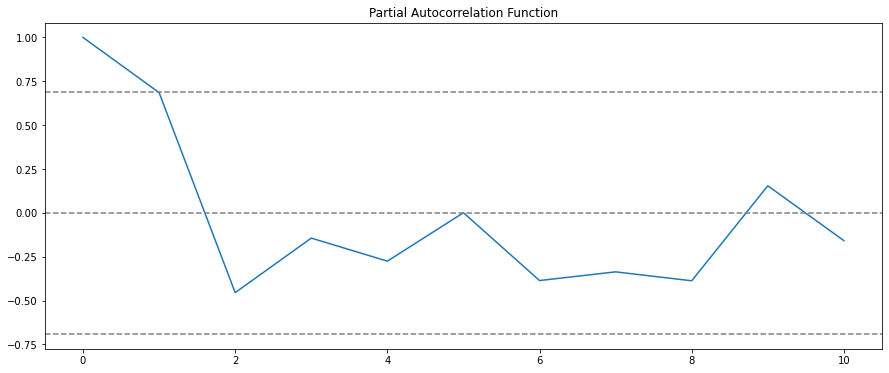

In [14]:
plt.plot(np.arange(0,11),pacf(ts_log_mvDif,nlags=10))
plt.axhline(y=0,linestyle="--",color="gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mvDif)),linestyle="--",color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_mvDif)),linestyle="--",color="gray")
plt.title("Partial Autocorrelation Function")
plt.show()

Text(0.5, 1.0, 'RSS: nan')

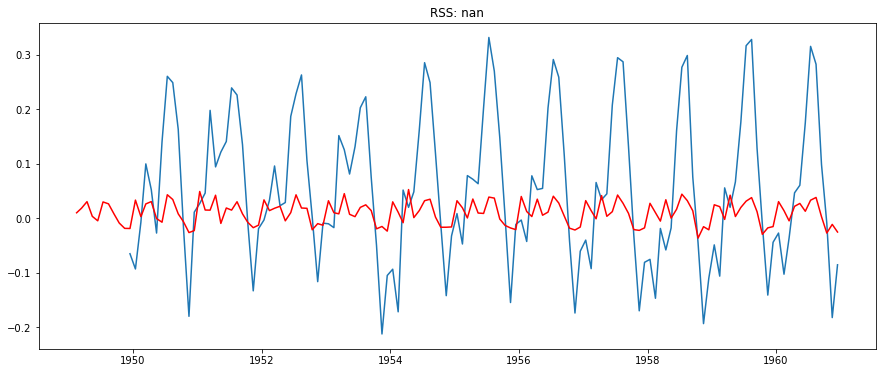

In [15]:
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mvDif)
plt.plot(results_ARIMA.fittedvalues,color="red")
plt.title("RSS: %.4f"%sum((results_ARIMA.fittedvalues[1:]-ts_log_mvDif)**2))

In [16]:
predictions_ARIMA_Dif = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_Dif.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [20]:
#cumulative sum cal
predictions_ARIMA_Dif_cumsum = predictions_ARIMA_Dif.cumsum()
predictions_ARIMA_Dif_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(ts_log,index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_Dif_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.780360
1949-03-15    4.910641
1949-04-15    4.917781
1949-05-15    4.856913
dtype: float64

Text(0.5, 1.0, 'RMSE: 626.8502')

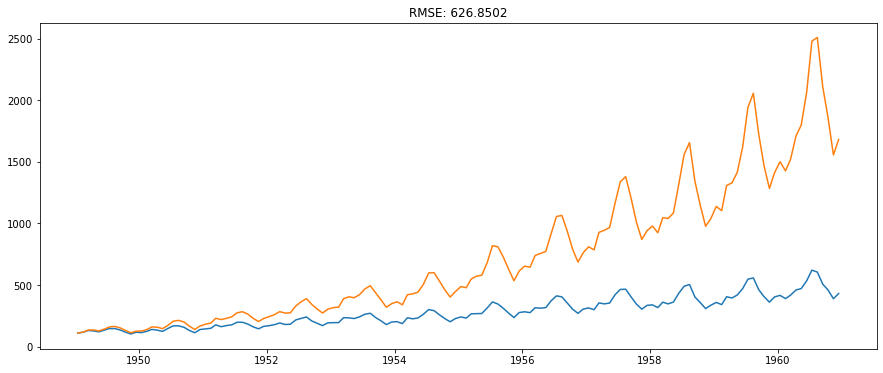

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title("RMSE: %.4f"%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))